## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

fileName = 'jet.bmp'    
url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

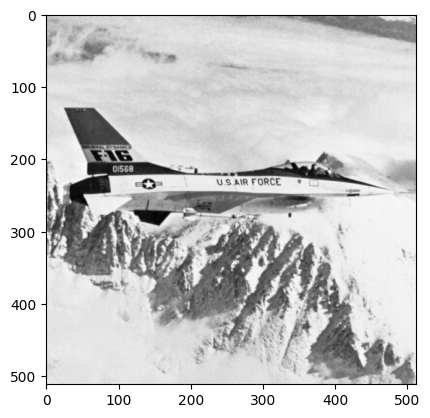

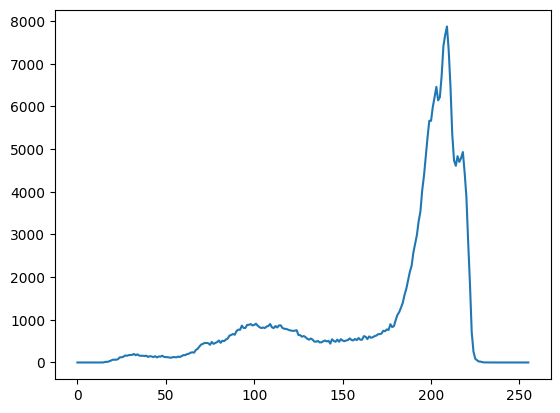

In [2]:
jet_image = cv2.imread("jet.bmp", cv2.IMREAD_GRAYSCALE)
plt.imshow(jet_image, 'gray')
hist = cv2.calcHist([jet_image], [0], None, [256], [0, 256])
plt.figure()
plt.plot(hist)
plt.show()


In [3]:
def calc_bbhe_treshold(image):
    return int(np.mean(image))

def calc_dsihe_treshold(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    histogram_cumulative = np.cumsum(hist)
    total_pixels = image.shape[0] * image.shape[1] 
    half_total_pixels = total_pixels / 2
    diff_array = np.abs(histogram_cumulative - half_total_pixels)
    return np.argmin(diff_array) 

In [4]:
bbhe_treshold = calc_bbhe_treshold(jet_image)
dsihe_threshold = calc_dsihe_treshold(jet_image)

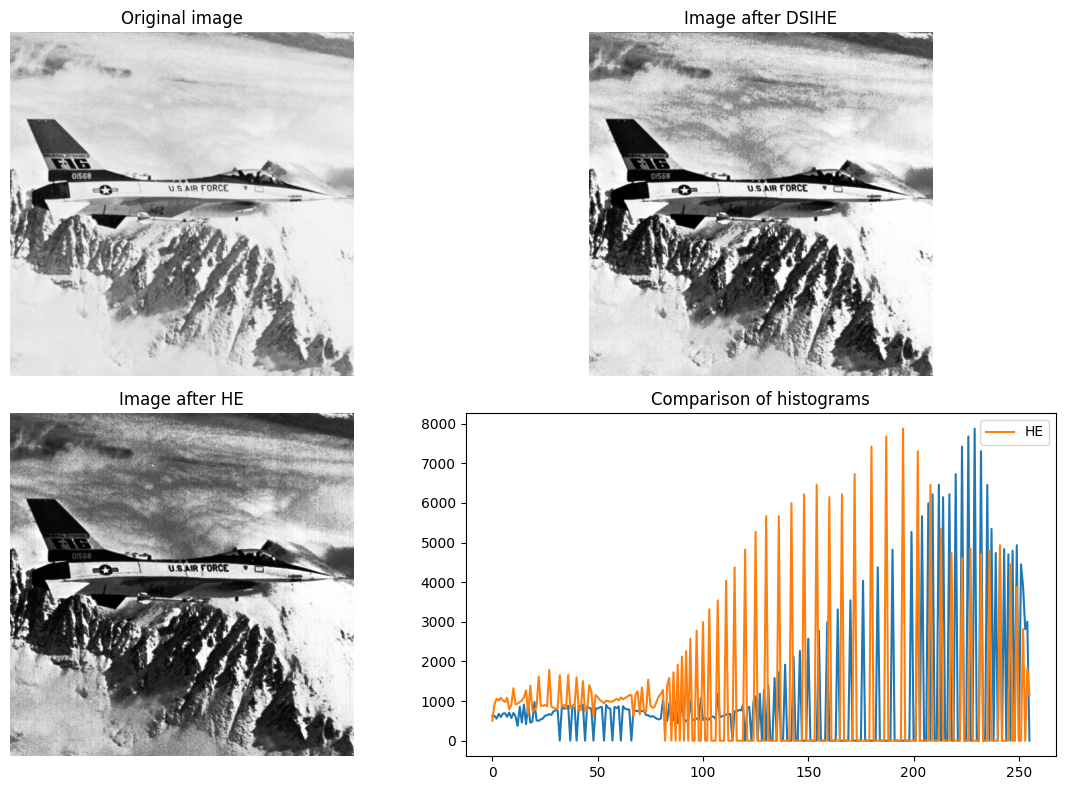

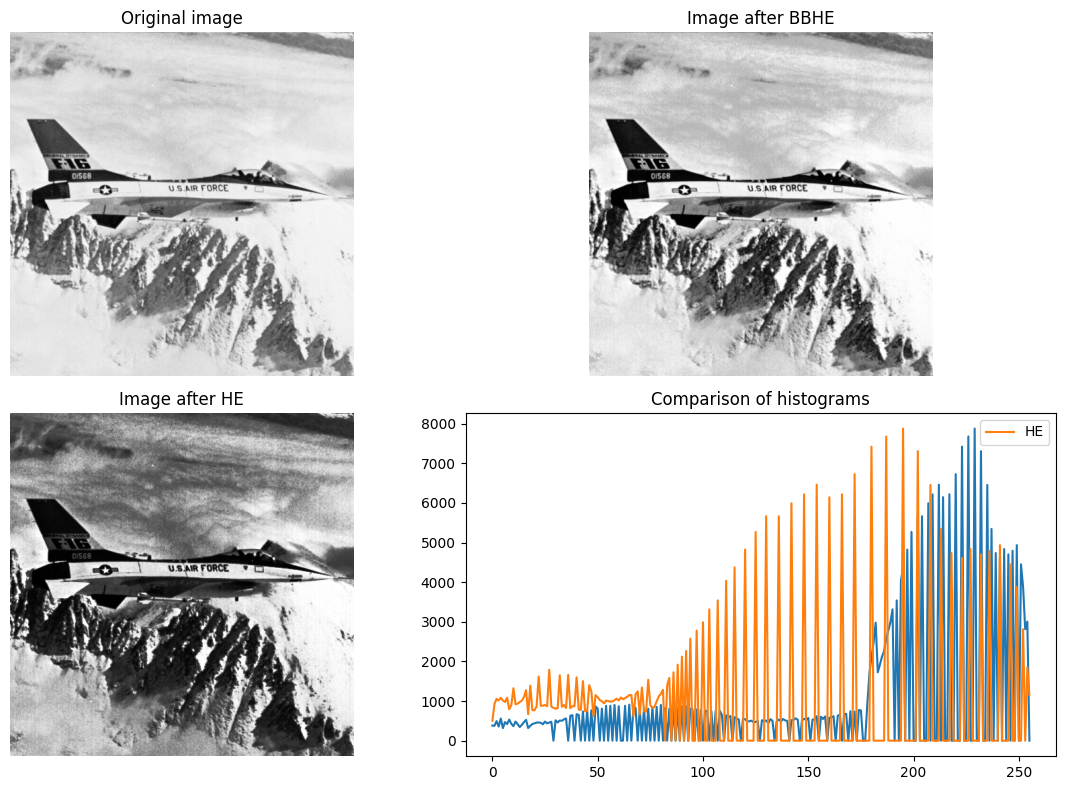

In [5]:
for threshold in [dsihe_threshold, bbhe_treshold]:
    H1 = hist[:threshold]        
    H2 = hist[threshold:]        

    C1 = np.cumsum(H1)
    C2 = np.cumsum(H2)

    C1_normalized = C1 / C1.max()  
    C2_normalized = C2 / C2.max()  

    C1n = (threshold) * C1_normalized  
    C2n = threshold + 1 + (255 - threshold - 1) * C2_normalized 

    lut = np.concatenate((C1n, C2n)).astype('uint8')

    equalized_image_dsihe = lut[jet_image]
    equalized_image_he = cv2.equalizeHist(jet_image)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.title("Original image")
    plt.imshow(jet_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Image after DSIHE") if threshold == dsihe_threshold else plt.title("Image after BBHE")
    plt.imshow(equalized_image_dsihe, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title("Image after HE")
    plt.imshow(equalized_image_he, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title("Comparison of histograms")
    plt.plot(np.histogram(equalized_image_dsihe, bins=256, range=(0, 256))[0])
    plt.plot(np.histogram(equalized_image_he, bins=256, range=(0, 256))[0], label="HE")
    plt.legend()

    plt.tight_layout()
    plt.show()
